# Training Dataset Size Variation

This script trains models for training sets of different sizes and measures energy and force error.
Model parameters are the best results from 1-MACE-parameters.ipynb.

In [1]:
# db = read('data/solvent_xtb.xyz', ':')
# write('data/solvent_xtb_train_200.xyz', db[:203]) #first 200 configs plus the 3 E0s
# write('data/solvent_xtb_train_400.xyz', db[:403])
# write('data/solvent_xtb_train_1000.xyz', db[:1003])
# write('data/solvent_xtb_train_2000.xyz', db[:2003])
# write('data/solvent_xtb_train_4000.xyz', db[:4003])

# write('data/solvent_xtb_test.xyz', db[-1000:]) #last 1000 configs

In [2]:
import time
import subprocess
import yaml
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def parse_log_file(log_path):
    with open(log_path, 'r') as f:
        lines = f.readlines()

    rmse_table_lines = [i for i, l in enumerate(lines) if "+-------------+---------------------+------------------+-------------------+" in l]
    if not rmse_table_lines:
        print("❌ No RMSE table found.")
        return None, None

    for idx in reversed(rmse_table_lines):
        for j in range(idx, min(idx + 10, len(lines))):
            if '|    valid    |' in lines[j]:
                parts = lines[j].strip().split('|')
                try:
                    rmse_e = float(parts[2].strip())
                    rmse_f = float(parts[3].strip())
                    print(f"✅ Found: RMSE_E = {rmse_e} meV, RMSE_F = {rmse_f} meV/Å")
                    return rmse_e, rmse_f
                except Exception as e:
                    print(f"❌ Error during parsing: {e}")
                    return None, None
    print("❌ Found no 'valid' line.")
    return None, None


In [4]:
# Base config from T01-MACE-Practice-I.ipynb
base_config = {
    'model': 'MACE',
    'num_interactions': 3,
    'num_channels': 64,
    'max_L': 2,
    'correlation': 3,
    'r_max': 4.0,
    'max_ell': 2,
    'model_dir': 'MACE_models',
    'log_dir': 'MACE_models',
    'checkpoints_dir': 'MACE_models',
    'results_dir': 'MACE_models',
    'test_file': 'data/solvent_xtb_test.xyz',
    'E0s': 'average',
    'energy_key': 'energy_xtb',
    'forces_key': 'forces_xtb',
    'device': 'cuda',
    'max_num_epochs': 50,
    'swa': True,
    'seed': 123,
    'batch_size': 10,
    'valid_fraction': 0.10
}

# Size of training data to be tested:
train_sizes = [200, 400, 1000, 2000, 4000]

In [5]:
# Save results
results = []

for size in train_sizes:
    name = f"train{size}"
    config = base_config.copy()
    config['name'] = f"mace_learncurve_{name}"
    config['train_file'] = f"data/solvent_xtb_train_{size}.xyz"

    cfg_path = f"benchmark_results/{config['name']}.yaml"
    Path("benchmark_results").mkdir(exist_ok=True)

    with open(cfg_path, 'w') as f:
        yaml.dump(config, f)

    print(f"\n🚀 Training started: {config['name']}")
    start = time.time()
    subprocess.run(['mace_run_train', '--config', cfg_path])
    runtime = time.time() - start

    log_path = f"MACE_models/{config['name']}_run-123.log"
    rmse_e, rmse_f = parse_log_file(log_path)

    results.append({
        'config': config['name'],
        'train_size': size,
        'train_time_s': round(runtime, 2),
        'rmse_e_meV': rmse_e,
        'rmse_f_meV': rmse_f
    })

# Save
df_lcurve = pd.DataFrame(results)
df_lcurve.sort_values("train_size")
df_lcurve.to_csv("benchmark_results/learning_curve_results.csv", index=False);


🚀 Training started: mace_learncurve_train200


/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

2025-06-03 20:49:52.334 INFO: MACE version: 0.3.6
2025-06-03 20:49:52.335 INFO: Configuration: Namespace(config='benchmark_results/mace_learncurve_train200.yaml', name='mace_learncurve_train200', seed=123, log_dir='MACE_models', model_dir='MACE_models', checkpoints_dir='MACE_models', results_dir='MACE_models', downloads_dir='downloads', device='cuda', default_dtype='float64', distributed=False, log_level='INFO', error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=2, correlation=3, num_interactions=3, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps='128x0e + 128x1o', num_channels=64, max_L=2, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='data/sol

/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: Us

2025-06-03 20:49:54.685 INFO: Using stochastic weight averaging (after 36 epochs) with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-06-03 20:49:54.805 INFO: ScaleShiftMACE(
  (node_embedding): LinearNodeEmbeddingBlock(
    (linear): Linear(3x0e -> 64x0e | 192 weights)
  )
  (radial_embedding): RadialEmbeddingBlock(
    (bessel_fn): BesselBasis(r_max=4.0, num_basis=8, trainable=False)
    (cutoff_fn): PolynomialCutoff(p=5.0, r_max=4.0)
  )
  (spherical_harmonics): SphericalHarmonics()
  (atomic_energies_fn): AtomicEnergiesBlock(energies=[-10.7072, -48.8474, -102.5712])
  (interactions): ModuleList(
    (0): RealAgnosticInteractionBlock(
      (linear_up): Linear(64x0e -> 64x0e | 4096 weights)
      (conv_tp): TensorProduct(64x0e x 1x0e+1x1o+1x2e -> 64x0e+64x1o+64x2e | 192 paths | 192 weights)
      (conv_tp_weights): FullyConnectedNet[8, 64, 64, 64, 192]
      (linear): Linear(64x0e+64x1o+64x2e -> 64x0e+64x1o+64x2e | 12288 weights)
      (skip_tp): FullyC

/usr/local/lib/python3.10/dist-packages/mace/tools/checkpoint.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-06-03 20:54:03.895 INFO: Evaluating valid ...
2025-06-03 20:54:04.115 INFO: Evaluating Default ...
2025-06-03 20:54:13.819 INFO: 
+-------------+---------------------+------------------+-------------------+
| config_type | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+-------------+---------------------+------------------+-------------------+
|    train    |        203.4        |      187.7       |        8.62       |
|    valid    |        219.7        |      217.3       |        8.40       |
|   Default   |        209.4        |      224.5       |        9.80       |
+-------------+---------------------+------------------+-------------------+
2025-06-03 20:54:13.819 INFO: Saving model to MACE_models/mace_learncurve_train200_run-123.model
2025-06-03 20:54:14.058 INFO: Compiling model, saving metadata to MACE_models/mace_learncurve_train200_compiled.model
2025-06-03 20:54:15.443 INFO: Loading checkpoint: MACE_models/mace_learncurve_train200_run-123_epoch-48_swa.pt


/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

2025-06-03 20:54:32.311 INFO: MACE version: 0.3.6
2025-06-03 20:54:32.311 INFO: Configuration: Namespace(config='benchmark_results/mace_learncurve_train400.yaml', name='mace_learncurve_train400', seed=123, log_dir='MACE_models', model_dir='MACE_models', checkpoints_dir='MACE_models', results_dir='MACE_models', downloads_dir='downloads', device='cuda', default_dtype='float64', distributed=False, log_level='INFO', error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=2, correlation=3, num_interactions=3, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps='128x0e + 128x1o', num_channels=64, max_L=2, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='data/sol

/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: Us

2025-06-03 20:54:34.861 INFO: Using stochastic weight averaging (after 36 epochs) with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-06-03 20:54:34.980 INFO: ScaleShiftMACE(
  (node_embedding): LinearNodeEmbeddingBlock(
    (linear): Linear(3x0e -> 64x0e | 192 weights)
  )
  (radial_embedding): RadialEmbeddingBlock(
    (bessel_fn): BesselBasis(r_max=4.0, num_basis=8, trainable=False)
    (cutoff_fn): PolynomialCutoff(p=5.0, r_max=4.0)
  )
  (spherical_harmonics): SphericalHarmonics()
  (atomic_energies_fn): AtomicEnergiesBlock(energies=[-10.7072, -48.8474, -102.5712])
  (interactions): ModuleList(
    (0): RealAgnosticInteractionBlock(
      (linear_up): Linear(64x0e -> 64x0e | 4096 weights)
      (conv_tp): TensorProduct(64x0e x 1x0e+1x1o+1x2e -> 64x0e+64x1o+64x2e | 192 paths | 192 weights)
      (conv_tp_weights): FullyConnectedNet[8, 64, 64, 64, 192]
      (linear): Linear(64x0e+64x1o+64x2e -> 64x0e+64x1o+64x2e | 12288 weights)
      (skip_tp): FullyC

/usr/local/lib/python3.10/dist-packages/mace/tools/checkpoint.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-06-03 21:02:51.934 INFO: Evaluating valid ...
2025-06-03 21:02:52.352 INFO: Evaluating Default ...
2025-06-03 21:03:02.059 INFO: 
+-------------+---------------------+------------------+-------------------+
| config_type | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+-------------+---------------------+------------------+-------------------+
|    train    |         35.0        |      150.5       |        6.09       |
|    valid    |         35.0        |      195.7       |        7.89       |
|   Default   |         36.2        |      167.6       |        7.32       |
+-------------+---------------------+------------------+-------------------+
2025-06-03 21:03:02.059 INFO: Saving model to MACE_models/mace_learncurve_train400_run-123.model
2025-06-03 21:03:02.290 INFO: Compiling model, saving metadata to MACE_models/mace_learncurve_train400_compiled.model
2025-06-03 21:03:03.662 INFO: Loading checkpoint: MACE_models/mace_learncurve_train400_run-123_epoch-48_swa.pt


/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

2025-06-03 21:03:22.174 INFO: MACE version: 0.3.6
2025-06-03 21:03:22.174 INFO: Configuration: Namespace(config='benchmark_results/mace_learncurve_train1000.yaml', name='mace_learncurve_train1000', seed=123, log_dir='MACE_models', model_dir='MACE_models', checkpoints_dir='MACE_models', results_dir='MACE_models', downloads_dir='downloads', device='cuda', default_dtype='float64', distributed=False, log_level='INFO', error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=2, correlation=3, num_interactions=3, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps='128x0e + 128x1o', num_channels=64, max_L=2, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='data/s

/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: Us

2025-06-03 21:03:25.396 INFO: Using stochastic weight averaging (after 36 epochs) with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-06-03 21:03:25.517 INFO: ScaleShiftMACE(
  (node_embedding): LinearNodeEmbeddingBlock(
    (linear): Linear(3x0e -> 64x0e | 192 weights)
  )
  (radial_embedding): RadialEmbeddingBlock(
    (bessel_fn): BesselBasis(r_max=4.0, num_basis=8, trainable=False)
    (cutoff_fn): PolynomialCutoff(p=5.0, r_max=4.0)
  )
  (spherical_harmonics): SphericalHarmonics()
  (atomic_energies_fn): AtomicEnergiesBlock(energies=[-10.7072, -48.8474, -102.5712])
  (interactions): ModuleList(
    (0): RealAgnosticInteractionBlock(
      (linear_up): Linear(64x0e -> 64x0e | 4096 weights)
      (conv_tp): TensorProduct(64x0e x 1x0e+1x1o+1x2e -> 64x0e+64x1o+64x2e | 192 paths | 192 weights)
      (conv_tp_weights): FullyConnectedNet[8, 64, 64, 64, 192]
      (linear): Linear(64x0e+64x1o+64x2e -> 64x0e+64x1o+64x2e | 12288 weights)
      (skip_tp): FullyC

/usr/local/lib/python3.10/dist-packages/mace/tools/checkpoint.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-06-03 21:24:12.334 INFO: Loaded model from epoch 34
2025-06-03 21:24:12.335 INFO: Evaluating train ...
2025-06-03 21:24:21.044 INFO: Evaluating valid ...
2025-06-03 21:24:21.990 INFO: Evaluating Default ...
2025-06-03 21:24:31.744 INFO: 
+-------------+---------------------+------------------+-------------------+
| config_type | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+-------------+---------------------+------------------+-------------------+
|    train    |         79.6        |      109.0       |        4.86       |
|    valid    |         81.0        |      105.5       |        4.89       |
|   Default   |         78.1        |      116.1       |        5.07       |
+-------------+---------------------+------------------+-------------------+
2025-06-03 21:24:31.745 INFO: Saving model to MACE_models/mace_learncurve_train1000_run-123.model
2025-06-03 21:24:31.964 INFO: Compiling model, saving metadata to MACE_models/mace_learncurve_train1000_compiled.model
2

/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

2025-06-03 21:24:57.711 INFO: MACE version: 0.3.6
2025-06-03 21:24:57.711 INFO: Configuration: Namespace(config='benchmark_results/mace_learncurve_train2000.yaml', name='mace_learncurve_train2000', seed=123, log_dir='MACE_models', model_dir='MACE_models', checkpoints_dir='MACE_models', results_dir='MACE_models', downloads_dir='downloads', device='cuda', default_dtype='float64', distributed=False, log_level='INFO', error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=2, correlation=3, num_interactions=3, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps='128x0e + 128x1o', num_channels=64, max_L=2, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='data/s

/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: Us

2025-06-03 21:25:02.214 INFO: Using stochastic weight averaging (after 36 epochs) with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-06-03 21:25:02.339 INFO: ScaleShiftMACE(
  (node_embedding): LinearNodeEmbeddingBlock(
    (linear): Linear(3x0e -> 64x0e | 192 weights)
  )
  (radial_embedding): RadialEmbeddingBlock(
    (bessel_fn): BesselBasis(r_max=4.0, num_basis=8, trainable=False)
    (cutoff_fn): PolynomialCutoff(p=5.0, r_max=4.0)
  )
  (spherical_harmonics): SphericalHarmonics()
  (atomic_energies_fn): AtomicEnergiesBlock(energies=[-10.7072, -48.8474, -102.5712])
  (interactions): ModuleList(
    (0): RealAgnosticInteractionBlock(
      (linear_up): Linear(64x0e -> 64x0e | 4096 weights)
      (conv_tp): TensorProduct(64x0e x 1x0e+1x1o+1x2e -> 64x0e+64x1o+64x2e | 192 paths | 192 weights)
      (conv_tp_weights): FullyConnectedNet[8, 64, 64, 64, 192]
      (linear): Linear(64x0e+64x1o+64x2e -> 64x0e+64x1o+64x2e | 12288 weights)
      (skip_tp): FullyC

/usr/local/lib/python3.10/dist-packages/mace/tools/checkpoint.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-06-03 22:07:03.992 INFO: Evaluating valid ...
2025-06-03 22:07:05.890 INFO: Evaluating Default ...
2025-06-03 22:07:15.676 INFO: 
+-------------+---------------------+------------------+-------------------+
| config_type | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+-------------+---------------------+------------------+-------------------+
|    train    |         56.2        |       85.7       |        3.80       |
|    valid    |         56.4        |       93.4       |        4.44       |
|   Default   |         54.9        |       93.6       |        4.09       |
+-------------+---------------------+------------------+-------------------+
2025-06-03 22:07:15.677 INFO: Saving model to MACE_models/mace_learncurve_train2000_run-123.model
2025-06-03 22:07:15.910 INFO: Compiling model, saving metadata to MACE_models/mace_learncurve_train2000_compiled.model
2025-06-03 22:07:17.170 INFO: Loading checkpoint: MACE_models/mace_learncurve_train2000_run-123_epoch-48_swa.

/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

2025-06-03 22:07:52.086 INFO: MACE version: 0.3.6
2025-06-03 22:07:52.086 INFO: Configuration: Namespace(config='benchmark_results/mace_learncurve_train4000.yaml', name='mace_learncurve_train4000', seed=123, log_dir='MACE_models', model_dir='MACE_models', checkpoints_dir='MACE_models', results_dir='MACE_models', downloads_dir='downloads', device='cuda', default_dtype='float64', distributed=False, log_level='INFO', error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=2, correlation=3, num_interactions=3, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps='128x0e + 128x1o', num_channels=64, max_L=2, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='data/s

/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: Us

2025-06-03 22:07:58.747 INFO: Using stochastic weight averaging (after 36 epochs) with energy weight : 1000.0, forces weight : 100.0 and learning rate : 0.001
2025-06-03 22:07:58.866 INFO: ScaleShiftMACE(
  (node_embedding): LinearNodeEmbeddingBlock(
    (linear): Linear(3x0e -> 64x0e | 192 weights)
  )
  (radial_embedding): RadialEmbeddingBlock(
    (bessel_fn): BesselBasis(r_max=4.0, num_basis=8, trainable=False)
    (cutoff_fn): PolynomialCutoff(p=5.0, r_max=4.0)
  )
  (spherical_harmonics): SphericalHarmonics()
  (atomic_energies_fn): AtomicEnergiesBlock(energies=[-10.7072, -48.8474, -102.5712])
  (interactions): ModuleList(
    (0): RealAgnosticInteractionBlock(
      (linear_up): Linear(64x0e -> 64x0e | 4096 weights)
      (conv_tp): TensorProduct(64x0e x 1x0e+1x1o+1x2e -> 64x0e+64x1o+64x2e | 192 paths | 192 weights)
      (conv_tp_weights): FullyConnectedNet[8, 64, 64, 64, 192]
      (linear): Linear(64x0e+64x1o+64x2e -> 64x0e+64x1o+64x2e | 12288 weights)
      (skip_tp): FullyC

/usr/local/lib/python3.10/dist-packages/mace/tools/checkpoint.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=checkpoint_info.path, map_location=device),


2025-06-03 23:33:29.133 INFO: Evaluating valid ...
2025-06-03 23:33:33.028 INFO: Evaluating Default ...
2025-06-03 23:33:42.768 INFO: 
+-------------+---------------------+------------------+-------------------+
| config_type | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+-------------+---------------------+------------------+-------------------+
|    train    |         58.7        |       79.8       |        3.48       |
|    valid    |         55.6        |       76.9       |        3.50       |
|   Default   |         57.6        |       80.9       |        3.53       |
+-------------+---------------------+------------------+-------------------+
2025-06-03 23:33:42.769 INFO: Saving model to MACE_models/mace_learncurve_train4000_run-123.model
2025-06-03 23:33:43.002 INFO: Compiling model, saving metadata to MACE_models/mace_learncurve_train4000_compiled.model
2025-06-03 23:33:44.252 INFO: Loading checkpoint: MACE_models/mace_learncurve_train4000_run-123_epoch-48_swa.

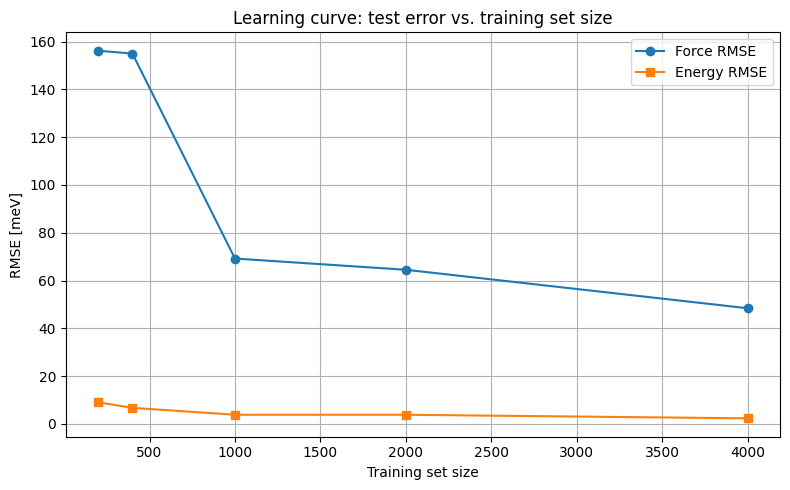

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df_lcurve = pd.read_csv("benchmark_results/learning_curve_results.csv")

plt.figure(figsize=(8, 5))
plt.plot(df_lcurve["train_size"], df_lcurve["rmse_f_meV"], marker='o', label="Force RMSE")
plt.plot(df_lcurve["train_size"], df_lcurve["rmse_e_meV"], marker='s', label="Energy RMSE")
plt.xlabel("Training set size")
plt.ylabel("RMSE [meV]")
plt.title("Learning curve: test error vs. training set size")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig("benchmark_results/learning_curve.png", dpi=300)

plt.show()